# Reynolds Number Analysis with PyDASA

This notebook demonstrates **dimensional analysis** of the Reynolds number using PyDASA's workflows. We'll explore how to:

1. Define physical variables with dimensions
2. Use PyDASA's `AnalysisEngine` to derive dimensionless groups
3. Understand the Reynolds number and its physical significance
4. Perform sensitivity analysis

## What is the Reynolds Number?

The **Reynolds number** (Re) is a dimensionless quantity that predicts flow patterns in fluid mechanics:

$$
Re = \frac{\rho \cdot v \cdot L}{\mu} = \frac{v \cdot L}{\nu}
$$

Where:
- $\rho$ (rho): Fluid density [kg/m³]
- $v$: Characteristic velocity [m/s]
- $L$: Characteristic length [m]
- $\mu$ (mu): Dynamic viscosity [Pa·s]
- $\nu$ (nu): Kinematic viscosity [m²/s]

**Physical Meaning:**
- **Re < 2300**: Laminar flow (smooth, ordered)
- **2300 < Re < 4000**: Transitional flow
- **Re > 4000**: Turbulent flow (chaotic, mixing)

## 1. Import Required Libraries

First, let's import PyDASA's core modules for dimensional analysis.

In [48]:
# PyDASA imports
import pydasa
from pydasa.workflows.phenomena import AnalysisEngine
from pydasa.elements.parameter import Variable

# For visualization and analysis
import numpy as np
import matplotlib.pyplot as plt

print(f"version: {pydasa.__version__}")
print("✓ PyDASA imported successfully!")

version: 0.6.2
✓ PyDASA imported successfully!


## 2. Define Physical Variables

We'll define all variables involved in pipe flow analysis with proper dimensions using PyDASA's `Variable` class.

**Variables for Complete Pipe Flow Analysis:**
1. **ρ** (density) - fluid mass per volume
2. **v** (velocity) - flow velocity
3. **D** (diameter) - pipe diameter
4. **μ** (viscosity) - fluid viscosity
5. **ΔP** (pressure drop) - pressure loss
6. **L** (length) - pipe length
7. **ε** (roughness) - absolute roughness height

These will generate three dimensionless coefficients:
- **Reynolds number**: Re = ρvD/μ
- **Relative roughness**: ε/D
- **Euler number** (related to friction factor): Eu = ΔP/(ρv²)

In [49]:
# Define the physical variables for Reynolds number analysis as dictionaries
# Each variable is stored with its symbol as the key

variables_dict = {
    # Fluid density: ρ [M/L³] - mass per unit volume
    "\\rho": {
        "_idx": 0,
        "_sym": "\\rho",
        "_alias": "rho",
        "_fwk": "PHYSICAL",
        "_cat": "IN",
        "_name": "Density",
        "description": "Fluid density (water at 20°C)",
        "relevant": True,
        "_dims": "M*L^-3",
        "_units": "kg/m³",
        "_setpoint": 1000.0,  # kg/m³ for water
        "_std_setpoint": 1000.0,  # kg/m³
        "_std_min": 990.0,  # kg/m³
        "_std_max": 1020.0,  # kg/m³
    },
    
    # Velocity: v [L/T] - characteristic velocity
    "v": {
        "_idx": 1,
        "_sym": "v",
        "_alias": "v",
        "_fwk": "PHYSICAL",
        "_cat": "IN",
        "_name": "Velocity",
        "description": "Characteristic flow velocity",
        "relevant": True,
        "_dims": "L*T^-1",
        "_units": "m/s",
        "_setpoint": 5.0,  # m/s
        "_std_setpoint": 5.0,  # m/s
        "_std_min": 1.0,  # m/s
        "_std_max": 6.0,  # m/s
    },
    
    # Pipe diameter: D [L]
    "D": {
        "_idx": 2,
        "_sym": "D",
        "_alias": "D",
        "_fwk": "PHYSICAL",
        "_cat": "IN",
        "_name": "Pipe Diameter",
        "description": "Internal pipe diameter",
        "relevant": True,
        "_dims": "L",
        "_units": "m",
        "_setpoint": 0.05,  # m (5 cm diameter pipe)
        "_std_setpoint": 0.05,  # m
        "_std_min": 0.04,  # m
        "_std_max": 0.06,  # m
    },
    
    # Dynamic viscosity: μ [M/(L·T)] - resistance to shear
    "\\mu": {
        "_idx": 3,
        "_sym": "\\mu",
        "_alias": "mu",
        "_fwk": "PHYSICAL",
        "_cat": "OUT",
        "_name": "Dynamic Viscosity",
        "description": "Dynamic (absolute) viscosity of fluid",
        "relevant": True,
        "_dims": "M*L^-1*T^-1",
        "_units": "Pa·s",
        "_setpoint": 0.001002,  # Pa·s for water at 20°C
        "_std_setpoint": 0.001002,  # Pa·s
        "_std_min": 0.0009,  # Pa·s
        "_std_max": 0.0011,  # Pa·s
    },
    
    # Pressure drop: ΔP [M/(L·T²)] - pressure loss along pipe
    "P": {
        "_idx": 4,
        "_sym": "P",
        "_alias": "Delta_P",
        "_fwk": "PHYSICAL",
        "_cat": "CTRL",
        "_name": "Pressure Drop",
        "description": "Pressure loss due to friction",
        "relevant": True,
        "_dims": "M*L^-1*T^-2",
        "_units": "Pa",
        "_setpoint": 5000.0,  # Pa (5 kPa typical for pipe flow)
        "_std_setpoint": 5000.0,  # Pa
        "_std_min": 4000.0,  # Pa
        "_std_max": 6000.0,  # Pa
    },
    
    # Pipe length: L_pipe [L]
    "L": {
        "_idx": 5,
        "_sym": "L",
        "_alias": "L",
        "_fwk": "PHYSICAL",
        "_cat": "CTRL",
        "_name": "Pipe Length",
        "description": "Length of pipe section",
        "relevant": True,
        "_dims": "L",
        "_units": "m",
        "_setpoint": 10.0,  # m (10 meter pipe)
        "_std_setpoint": 10.0,  # m
        "_std_min": 8.0,  # m
        "_std_max": 12.0,  # m
    },
    
    # Pipe roughness: ε [L] - absolute roughness height
    "\\varepsilon": {
        "_idx": 6,
        "_sym": "\\varepsilon",
        "_alias": "epsilon",
        "_fwk": "PHYSICAL",
        "_cat": "CTRL",
        "_name": "Absolute Roughness",
        "description": "Pipe wall absolute roughness height",
        "relevant": True,
        "_dims": "L",
        "_units": "m",
        "_setpoint": 0.000025,  # m (0.045 mm for commercial steel)
        "_std_setpoint": 0.000025,  # m
        "_std_min": 0.00002,  # m
        "_std_max": 0.00003,  # m
    }
}

# Convert dictionaries to Variable instances
variables = {
    sym: Variable(**params) for sym, params in variables_dict.items()
}

print("✓ Variables defined:")
print(f"{'Symbol':<15} {'Setpoint':<15} {'Units':<10} {'Dimensions':<20} {'Category':<10}")
print("-" * 70)
for sym, var in variables.items():
    print(f"{sym:<15} {var.setpoint:<15} {var.units:<10} {var.dims:<20} {var.cat:<10}")

✓ Variables defined:
Symbol          Setpoint        Units      Dimensions           Category  
----------------------------------------------------------------------
\rho            1000.0          kg/m³      M*L^-3               IN        
v               5.0             m/s        L*T^-1               IN        
D               0.05            m          L                    IN        
\mu             0.001002        Pa·s       M*L^-1*T^-1          OUT       
P               5000.0          Pa         M*L^-1*T^-2          CTRL      
L               10.0            m          L                    CTRL      
\varepsilon     2.5e-05         m          L                    CTRL      


## 3. Create Dimensional Analysis Engine

Now we'll use PyDASA's **AnalysisEngine** (main workflow) to automatically derive dimensionless groups using the Buckingham Pi theorem.

In [50]:
# Create the dimensional analysis engine
engine = AnalysisEngine(
    _idx=0,
    _fwk="PHYSICAL",
    _name="Pipe Flow Analysis",
    description="Dimensional analysis for Reynolds number, Darcy friction factor, and relative roughness"
)

# Add all variables to the engine
engine.variables = variables

print("*** AnalysisEngine Created ***")
print(f"Framework: {engine.fwk}")
print(f"Variables: {len(variables)}")
n_inputs = sum(1 for v in variables.values() if v.cat == "IN")
print(f"\t- Input variables: {n_inputs}")
n_outputs = sum(1 for v in variables.values() if v.cat == "OUT")
print(f"\t- Output variables: {n_outputs}")
n_controls = sum(1 for v in variables.values() if v.cat == "CTRL")
print(f"\t- Control variables: {n_controls}")
print(f"Engine Framework: {engine.fwk}")

*** AnalysisEngine Created ***
Framework: PHYSICAL
Variables: 7
	- Input variables: 3
	- Output variables: 1
	- Control variables: 3
Engine Framework: PHYSICAL


## 4. Run Dimensional Analysis

Execute the complete workflow to generate dimensionless coefficients (Pi groups).

In [51]:
# Run the complete dimensional analysis workflow
results = engine.run_analysis()

print(f"✓ Analysis complete!")
print(f"  Number of dimensionless groups: {len(engine.coefficients)}")
print(f"  Coefficients generated: {list(engine.coefficients.keys())}\n")

# Display coefficients in a formatted table
print("=" * 80)
print(f"{'Coefficient':<15} {'Expression':<30} {'Variable Exponents':<35}")
print("=" * 80)

for name, coeff in engine.coefficients.items():

    # extract the coefficient expression
    expression = str(coeff.pi_expr) if len(str(coeff.pi_expr)) < 30 else str(coeff.pi_expr)[:27] + "..."
    # Format variable exponents as a compact string
    exponents_str = ", ".join([f"{var}^{exp}" if exp != 1 else var
                               for var, exp in coeff.var_dims.items()])

    print(f"{name:<15} {expression:<30} {exponents_str:<55}")

print("=" * 80)

✓ Analysis complete!
  Number of dimensionless groups: 4
  Coefficients generated: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}']

Coefficient     Expression                     Variable Exponents                 
\Pi_{0}         \frac{\mu}{\rho*v*D}           \rho^-1, v^-1, D^-1, \mu                               
\Pi_{1}         \frac{P}{\rho*v^{2}}           \rho^-1, v^-2, P                                       
\Pi_{2}         \frac{L}{D}                    D^-1, L                                                
\Pi_{3}         \frac{\varepsilon}{D}          D^-1, \varepsilon                                      


## 5. Examine the Dimensionless Coefficients

Let's inspect the dimensionless coefficients that PyDASA computed. We expect to see combinations representing:
- **Reynolds Number (Re)**: Flow regime predictor
- **Preassure Drop Coefficient (Pd)**: Pressure loss coefficient
- **Relative Roughness (ε/D)**: Surface roughness effect

In [52]:
# Analyze each dimensionless coefficient in table format
print("=" * 100)
print("DIMENSIONLESS COEFFICIENTS ANALYSIS")
print("=" * 100)
print(f"{'Coefficient':<15} {'Name':<25} {'Expression':<30} {'Variables':<30}")
print("=" * 100)

for pi_symbol, pi_coeff in engine._coefficients.items():
    var_exp_str = ", ".join([f"{var}^{exp}" if exp != 1 else var 
                             for var, exp in pi_coeff.var_dims.items()])
    expr_str = str(pi_coeff.pi_expr)[:28] + "..." if len(str(pi_coeff.pi_expr)) > 30 else str(pi_coeff.pi_expr)
    print(f"{pi_symbol:<15} {pi_coeff.name:<25} {expr_str:<30} {var_exp_str:<30}")

print("=" * 100)

# Get variable values
rho = variables["\\rho"].setpoint
v = variables["v"].setpoint
D = variables["D"].setpoint
mu = variables["\\mu"].setpoint
Delta_P = variables["P"].setpoint
L = variables["L"].setpoint
epsilon = variables["\\varepsilon"].setpoint

# Calculate Reynolds Number
Re = (rho * v * D) / mu      # type: ignore
rel_roughness = epsilon / D     # type: ignore

# Calculate Darcy Friction Factor
if Re > 4000:
    f = 0.25 / (np.log10(rel_roughness/3.7 + 5.74/Re**0.9))**2
    flow_regime = "TURBULENT"
    f_method = "Swamee-Jain"
elif Re < 2300:
    f = 64 / Re
    flow_regime = "LAMINAR"
    f_method = "f = 64/Re"
else:
    f = 0.04
    flow_regime = "TRANSITIONAL"
    f_method = "Approximation"

# Calculate pressure drop
Delta_P_calculated = f * (L/D) * (rho * v**2 / 2)       # type: ignore

# Display calculated values in table format
print("\n" + "=" * 100)
print("CALCULATED DIMENSIONLESS NUMBERS AND PARAMETERS")
print("=" * 100)
print(f"{'Parameter':<30} {'Value':<20} {'Units/Info':<50}")
print("=" * 100)
print(f"{'Reynolds Number (Re)':<30} {Re:<20.4e} {flow_regime:<50}")
print(f"{'Relative Roughness (ε/D)':<30} {rel_roughness:<20.6e} {'Commercial steel (ε = 0.045 mm)':<50}")
print(f"{'Darcy Friction Factor (f)':<30} {f:<20.6f} {f_method:<50}")
print(f"{'Pressure Drop (ΔP calc)':<30} {Delta_P_calculated:<20.2f} {'Pa (from Darcy-Weisbach equation)':<50}")
print(f"{'Pressure Drop (ΔP given)':<30} {Delta_P:<20.2f} {'Pa':<50}")
print(f"{'ΔP Ratio (calc/given)':<30} {Delta_P_calculated / Delta_P:<20.3f} {'Agreement check':<50}")   # type: ignore
print("=" * 100)

DIMENSIONLESS COEFFICIENTS ANALYSIS
Coefficient     Name                      Expression                     Variables                     
\Pi_{0}         Pi-0                      \frac{\mu}{\rho*v*D}           \rho^-1, v^-1, D^-1, \mu      
\Pi_{1}         Pi-1                      \frac{P}{\rho*v^{2}}           \rho^-1, v^-2, P              
\Pi_{2}         Pi-2                      \frac{L}{D}                    D^-1, L                       
\Pi_{3}         Pi-3                      \frac{\varepsilon}{D}          D^-1, \varepsilon             

CALCULATED DIMENSIONLESS NUMBERS AND PARAMETERS
Parameter                      Value                Units/Info                                        
Reynolds Number (Re)           2.4950e+05           TURBULENT                                         
Relative Roughness (ε/D)       5.000000e-04         Commercial steel (ε = 0.045 mm)                   
Darcy Friction Factor (f)      0.018583             Swamee-Jain                       

## 6. Derive Key Dimensionless Coefficients

Now let's use PyDASA's `derive_coefficient()` method to create physically meaningful coefficients:

1. **Reynolds Number (Re)**: Flow regime predictor - Re = ρvD/μ = 1/Π₀
2. **Pressure Drop Ratio (Pd)**: Relates to pressure drop - derived from Π₁ and Π₃
3. **Relative Roughness (ε/D)**: Surface roughness effect - same as Π₂

These derived coefficients connect directly to the Moody diagram we'll construct.

In [53]:
# Get the original Pi coefficients
pi_keys = list(engine.coefficients.keys())
# print(f"Original Pi coefficients: {pi_keys}\n")

# Derive Reynolds Number: Re = 1/Π₀ = ρvD/μ
Re_coeff = engine.derive_coefficient(
    expr=f"1/{pi_keys[0]}",
    symbol="Re",
    name="Reynolds Number",
    description="Re = ρvD/μ - Predicts flow regime (laminar/turbulent)",
    idx=-1
)

# Derive Darcy Friction Factor base: Related to Π₁ and Π2
# Standard Darcy: f = 2·(D·ΔP)/(L·ρ·v²) = 2·(D/L)·(ΔP/(ρ·v²)) = 2·(1/Π₁)·Π₃
f_coeff = engine.derive_coefficient(
    expr=f"2*{pi_keys[1]}^-1 * {pi_keys[2]}",
    symbol="Pd",
    name="Pressure Drop Ratio",
    description="Pd = 2(D/L)(P/(ρv²)) - Pressure Drop Ratio",
    idx=-1
)

# Derive Relative Roughness: ε/D = Π₃ (or Π₃)
# The derive_coefficient method handles the expression correctly using sympy
rough_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[3]}",
    symbol="\\epsilon/D",
    name="Relative Roughness",
    description="ε/D - Dimensionless surface roughness",
    idx=-1
)

# Calculate numerical values using stored setpoints
Re_value = Re_coeff.calculate_setpoint()
f_value = f_coeff.calculate_setpoint()
rough_value = rough_coeff.calculate_setpoint()

# Display results
print("=" * 100)
print("DERIVED DIMENSIONLESS COEFFICIENTS")
print("=" * 100)
print(f"{'Coefficient':<20} {'Expression':<35} {'Value':<15} {'Description':<30}")
print("=" * 100)
print(f"{'Reynolds Number':<20} {str(Re_coeff.pi_expr):<35} {Re_value:<15.4e} {'Flow regime predictor':<30}")
print(f"{'Pressure Drop Ratio':<20} {str(f_coeff.pi_expr)[:35]:<35} {f_value:<15.6f} {'Pressure drop':<30}")
print(f"{'Rel. Roughness':<20} {str(rough_coeff.pi_expr):<35} {rough_value:<15.6e} {'Surface roughness':<30}")
print("=" * 100)

# Determine flow regime
if Re_value > 4000:
    regime = "TURBULENT"
elif Re_value < 2300:
    regime = "LAMINAR"
else:
    regime = "TRANSITIONAL"
    
print(f"\nFlow Regime: {regime} (Re = {Re_value:.2e})")
print("=" * 100)

DERIVED DIMENSIONLESS COEFFICIENTS
Coefficient          Expression                          Value           Description                   
Reynolds Number      \frac{\rho*v*D}{\mu}                2.4950e+05      Flow regime predictor         
Pressure Drop Ratio  2*\frac{P*L}{\rho*v^{2}*D}          40.000000       Pressure drop                 
Rel. Roughness       \frac{\varepsilon}{D}               5.000000e-04    Surface roughness             

Flow Regime: TURBULENT (Re = 2.50e+05)


## 7. Sensitivity Analysis

Let's use PyDASA's **SensitivityAnalysis** workflow to understand which variables have the most influence on our dimensionless coefficients.

In [64]:
# Import SensitivityAnalysis workflow
from pydasa.workflows.influence import SensitivityAnalysis

# Create sensitivity analysis handler
sensitivity = SensitivityAnalysis(
    _idx=0,
    _fwk="PHYSICAL",
    _name="Reynolds Sensitivity Analysis",
    _cat="SYM"  # Symbolic sensitivity analysis
)

# Configure with variables and coefficients from the engine
sensitivity.variables = engine.variables
sensitivity.coefficients = engine.coefficients

print("===== ✓ SensitivityAnalysis workflow created =====")
print(f"\tFramework: {sensitivity.fwk}")
print(f"\tAnalysis type: {sensitivity.cat} (Symbolic)")
print(f"\tVariables: {len(sensitivity.variables)}")
print(f"\tCoefficients to analyze: {len(sensitivity.coefficients)}")

# Run symbolic sensitivity analysis at mean values
print("\n--- Running Symbolic Sensitivity Analysis ---")
sensitivity_results = sensitivity.analyze_symbolic(val_type="mean")

print(f"===== ✓ Symbolic sensitivity analysis complete! =====")
print(f"\tAnalyzed {len(sensitivity_results)} coefficients")
print(f"\tResults available for: {list(sensitivity_results.keys())}")

===== ✓ SensitivityAnalysis workflow created =====
	Framework: PHYSICAL
	Analysis type: SYM (Symbolic)
	Variables: 7
	Coefficients to analyze: 7

--- Running Symbolic Sensitivity Analysis ---
===== ✓ Symbolic sensitivity analysis complete! =====
	Analyzed 7 coefficients
	Results available for: ['SEN_{\\Pi_{0}}', 'SEN_{\\Pi_{1}}', 'SEN_{\\Pi_{2}}', 'SEN_{\\Pi_{3}}', 'SEN_{Re}', 'SEN_{Pd}', 'SEN_{\\epsilon/D}']


In [71]:
# Display sensitivity analysis results in formatted tables
print("=" * 120)
print("SENSITIVITY ANALYSIS RESULTS - Symbolic Differentiation at Mean Values")
print("=" * 120)

# Get the derived coefficients we care about (Re, Pd, ε/D)
derived_coeff_keys = [k for k in sensitivity_results.keys() if not k.startswith('\\Pi_')]

for coeff_key in sensitivity_results.keys():
    sens_data = sensitivity_results[coeff_key]
    
    # Get coefficient name
    if coeff_key in engine.coefficients:
        coeff_name = engine.coefficients[coeff_key].name
    else:
        coeff_name = coeff_key
    
    print(f"\n{'Coefficient':<25} {coeff_key:<20} ({coeff_name})")
    print("-" * 120)
    print(f"{'Variable':<20} {'Sensitivity':<20} {'Relative Impact (%)':<25} {'Description':<55}")
    print("-" * 120)
    
    # Calculate total sensitivity for relative percentages
    total_sens = sum(abs(v) for v in sens_data.values() if isinstance(v, (int, float)))
    
    # Sort by absolute sensitivity (descending)
    sorted_vars = sorted(sens_data.items(), key=lambda x: abs(x[1]) if isinstance(x[1], (int, float)) else 0, reverse=True)
    
    for var_sym, sens_val in sorted_vars:
        if isinstance(sens_val, (int, float)):
            # Get variable name
            if var_sym in engine.variables:
                var_name = engine.variables[var_sym].name
            else:
                var_name = var_sym
            
            # Calculate relative impact
            rel_impact = (abs(sens_val) / total_sens * 100) if total_sens > 0 else 0
            
            # Format sensitivity value
            sens_str = f"{sens_val:+.4e}"
            
            # Impact description
            if rel_impact > 40:
                impact_desc = "🔴 DOMINANT influence"
            elif rel_impact > 20:
                impact_desc = "🟠 MAJOR influence"
            elif rel_impact > 10:
                impact_desc = "🟡 MODERATE influence"
            else:
                impact_desc = "🟢 MINOR influence"
            
            print(f"{var_sym:<20} {sens_str:<20} {rel_impact:<25.2f} {impact_desc:<55}")

print("\n" + "=" * 120)

SENSITIVITY ANALYSIS RESULTS - Symbolic Differentiation at Mean Values

Coefficient               SEN_{\Pi_{0}}        (SEN_{\Pi_{0}})
------------------------------------------------------------------------------------------------------------------------
Variable             Sensitivity          Relative Impact (%)       Description                                            
------------------------------------------------------------------------------------------------------------------------
D                    +1.0000e+00          25.00                     🟠 MAJOR influence                                      
\mu                  -1.0000e+00          25.00                     🟠 MAJOR influence                                      
\rho                 +1.0000e+00          25.00                     🟠 MAJOR influence                                      
v                    +1.0000e+00          25.00                     🟠 MAJOR influence                                      

Co

## 8. Monte Carlo Simulation for Uncertainty Analysis

Now let's use PyDASA's **MonteCarloSimulation** workflow to:
1. Generate variations in input parameters (velocity, diameter, etc.)
2. Calculate resulting Reynolds numbers and friction factors
3. Create data points for plotting the Moody diagram

In [66]:
# Import MonteCarloSimulation workflow
from pydasa.workflows.practical import MonteCarloSimulation
import random

# IMPORTANT: We need to ensure ALL variables in coefficients have distributions
# First, let's see what variables are actually used in the coefficients
print("===== Checking variables in coefficients =====")
all_coef_vars = set()
for coef_sym, coef in engine.coefficients.items():
    print(f"\t{coef_sym}: {list(coef.var_dims.keys())}")
    all_coef_vars.update(coef.var_dims.keys())
print(f"\nAll unique variables in coefficients: {sorted(all_coef_vars)}")
print(f"\tVariables in engine: {sorted(engine.variables.keys())}\n")

for var_sym, var in engine.variables.items():
    if var_sym == "v":
        # Vary velocity from 1.0 to 5.0 m/s - REALISTIC pipe flow range
        # Re range: ~25,000 to ~250,000 (typical turbulent pipe flow)
        a = 1.0
        b = 5.0
        var._dist_params = {"a": a, "b": b}
        var._dist_type = "uniform"
        var._dist_func = lambda a=a, b=b: random.uniform(a, b)
    elif var_sym == "D":
        # Keep diameter with small variation around 5 cm
        a = 0.049
        b = 0.051
        var._dist_params = {"a": a, "b": b}
        var._dist_func = lambda a=a, b=b: random.uniform(a, b)
        var._dist_type = "uniform"
    elif var_sym == "\\rho":
        # Vary density slightly around water at 20°C (980-1020 kg/m³)
        a = 980.0
        b = 1020.0
        var._dist_params = {"a": a, "b": b}
        var._dist_type = "uniform"
        var._dist_func = lambda a=a, b=b: random.uniform(a, b)
    elif var_sym == "\\mu":
        # Viscosity kept constant (at 0.001002 Pa·s)
        cst = var.setpoint
        var._dist_type = "constant"
        var._dist_params = {"value": var.setpoint}
        var._dist_func = lambda cst=cst: cst
    elif var_sym == "P":
        # Pressure drop kept constant (at 5000 Pa)
        cst = var.setpoint
        var._dist_type = "constant"
        var._dist_params = {"value": var.setpoint}
        var._dist_func = lambda cst=cst: cst
    elif var_sym == "L":
        # Length kept constant (at 10 m)
        cst = var.setpoint
        var._dist_type = "constant"
        var._dist_params = {"value": var.setpoint}
        var._dist_func = lambda cst=cst: cst
    elif var_sym == "\\varepsilon":
        # Roughness kept constant (at 0.000025 m)
        cst = var.setpoint
        var._dist_type = "constant"
        var._dist_params = {"value": var.setpoint}
        var._dist_func = lambda cst=cst: cst

print("✓ All distributions configured")

# Create Monte Carlo simulation handler
mc_handler = MonteCarloSimulation(
    _idx=0,
    _fwk="PHYSICAL",
    _name="Reynolds Monte Carlo",
    _cat="DIST",                    # Distribution-based sampling
    _experiments=500,               # Number of simulation runs
    _variables=engine.variables,    # Use variables from engine
    _coefficients=engine.coefficients
)

# Run the simulation
print("\nRunning Monte Carlo simulation...")
mc_handler.run_simulation(iters=500)

print("--- ✓ Monte Carlo simulation complete! ---")
print(f"\tExperiments run: {mc_handler.experiments}")
print(f"\tCoefficients analyzed: {list(mc_handler.simulations.keys())}")
print(f"\tResults available for: {list(mc_handler.results.keys())}")

===== Checking variables in coefficients =====
	\Pi_{0}: ['\\rho', 'v', 'D', '\\mu']
	\Pi_{1}: ['\\rho', 'v', 'P']
	\Pi_{2}: ['D', 'L']
	\Pi_{3}: ['D', '\\varepsilon']
	Re: ['\\rho', 'v', 'D', '\\mu']
	Pd: ['\\rho', 'v', 'D', 'P', 'L']
	\epsilon/D: ['D', '\\varepsilon']

All unique variables in coefficients: ['D', 'L', 'P', '\\mu', '\\rho', '\\varepsilon', 'v']
	Variables in engine: ['D', 'L', 'P', '\\mu', '\\rho', '\\varepsilon', 'v']

✓ All distributions configured

Running Monte Carlo simulation...
--- ✓ Monte Carlo simulation complete! ---
	Experiments run: 500
	Coefficients analyzed: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', 'Re', 'Pd', '\\epsilon/D']
	Results available for: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', 'Re', 'Pd', '\\epsilon/D']


In [67]:
# Can extract simulation results from ORIGINAL Pi coefficients, or the derived values
# The Monte Carlo simulation ran with the original and derived derived coefficients

# Get the ORIGINAL Pi coefficient names
all_keys = list(mc_handler.simulations.keys())

# Filter to get only the original Pi coefficients (they start with \\Pi_)
pi_keys = [k for k in all_keys if k.startswith('\\Pi_')]
print(f"Original Pi coefficients in simulation: {pi_keys}")

# Also check for derived coefficients
derived_keys = [k for k in all_keys if not k.startswith('\\Pi_')]
print(f"Derived coefficients in simulation: {derived_keys}\n")

# Extract derived Pi coefficients
print("--- Extracting Derived Pi Coefficients from Simulation ---")
pi_data = {}
for pi_key in derived_keys:
    pi_sim_obj = mc_handler.get_simulation(pi_key)
    pi_results = pi_sim_obj.extract_results()
    pi_data[pi_key] = pi_results[pi_key]
    print(f"\t{pi_key}: Mean = {np.mean(pi_data[pi_key]):.6e}, Range = [{np.min(pi_data[pi_key]):.6e}, {np.max(pi_data[pi_key]):.6e}]")

print("\n--- Computing Derived Coefficients from Pi Groups ---")

# Compute Re = 1/Π₀ (where Π₀ = μ/(ρvD))
Re_sim = pi_data[all_keys[4]]
print(f"Reynolds Number (Re = 1/Π₀): Mean = {np.mean(Re_sim):.6e}")

# Compute ε/D from Π₃v directly
epsilon_D_sim = pi_data[all_keys[6]]  # Direct assignment
print(f"Relative Roughness (from Π₃): Mean = {np.mean(epsilon_D_sim):.6e}")

# Calculate friction factor from Reynolds number and roughness using Colebrook-White function
# f = 0.25 / [log10(ε/D/3.7 + 5.74/Re^0.9)]²
f_sim = np.zeros_like(Re_sim)

for i in range(len(Re_sim)):
    Re_val = Re_sim[i]
    rel_rough = epsilon_D_sim[i]
    
    if Re_val < 2300:
        # Laminar flow: f = 64/Re
        f_sim[i] = 64.0 / Re_val
    else:
        # Turbulent flow: Swamee-Jain approximation to Colebrook-White
        f_sim[i] = 0.25 / (np.log10(rel_rough/3.7 + 5.74/Re_val**0.9))**2

# Display simulation statistics
print("=" * 100)
print("MONTE CARLO SIMULATION RESULTS - DERIVED COEFFICIENTS")
print("=" * 100)
print(f"{'Parameter':<30} {'Mean':<15} {'Std Dev':<15} {'Min':<15} {'Max':<15}")
print("=" * 100)
print(f"{'Reynolds Number (Re)':<30} {np.mean(Re_sim):<15.2e} {np.std(Re_sim):<15.2e} {np.min(Re_sim):<15.2e} {np.max(Re_sim):<15.2e}")
print(f"{'Friction Factor (f)':<30} {np.mean(f_sim):<15.6f} {np.std(f_sim):<15.6f} {np.min(f_sim):<15.6f} {np.max(f_sim):<15.6f}")
print(f"{'Relative Roughness (ε/D)':<30} {np.mean(epsilon_D_sim):<15.6e} {np.std(epsilon_D_sim):<15.6e} {np.min(epsilon_D_sim):<15.6e} {np.max(epsilon_D_sim):<15.6e}")
print("=" * 100)

# Count laminar vs turbulent points
laminar_count = np.sum(Re_sim < 2300)
transition_count = np.sum((Re_sim >= 2300) & (Re_sim < 4000))
turbulent_count = np.sum(Re_sim >= 4000)

print(f"\n--- Flow Regime Distribution: ---")
print(f"\tLaminar (Re < 2300): {laminar_count} ({100*laminar_count/len(Re_sim):.1f}%)")
print(f"\tTransition (2300 ≤ Re < 4000): {transition_count} ({100*transition_count/len(Re_sim):.1f}%)")
print(f"\tTurbulent (Re ≥ 4000): {turbulent_count} ({100*turbulent_count/len(Re_sim):.1f}%)")
print("=" * 100)

Original Pi coefficients in simulation: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}']
Derived coefficients in simulation: ['Re', 'Pd', '\\epsilon/D']

--- Extracting Derived Pi Coefficients from Simulation ---
	Re: Mean = 1.511321e+05, Range = [5.117572e+04, 2.464613e+05]
	Pd: Mean = 3.920326e+02, Range = [8.174176e+01, 1.932052e+03]
	\epsilon/D: Mean = 4.999467e-04, Range = [4.902342e-04, 5.101569e-04]

--- Computing Derived Coefficients from Pi Groups ---
Reynolds Number (Re = 1/Π₀): Mean = 1.511321e+05
Relative Roughness (from Π₃): Mean = 4.999467e-04
MONTE CARLO SIMULATION RESULTS - DERIVED COEFFICIENTS
Parameter                      Mean            Std Dev         Min             Max            
Reynolds Number (Re)           1.51e+05        5.65e+04        5.12e+04        2.46e+05       
Friction Factor (f)            0.019761        0.001034        0.018571        0.022531       
Relative Roughness (ε/D)       4.999467e-04    5.555998e-06    4.902342e-04    5.101569e-04   

-

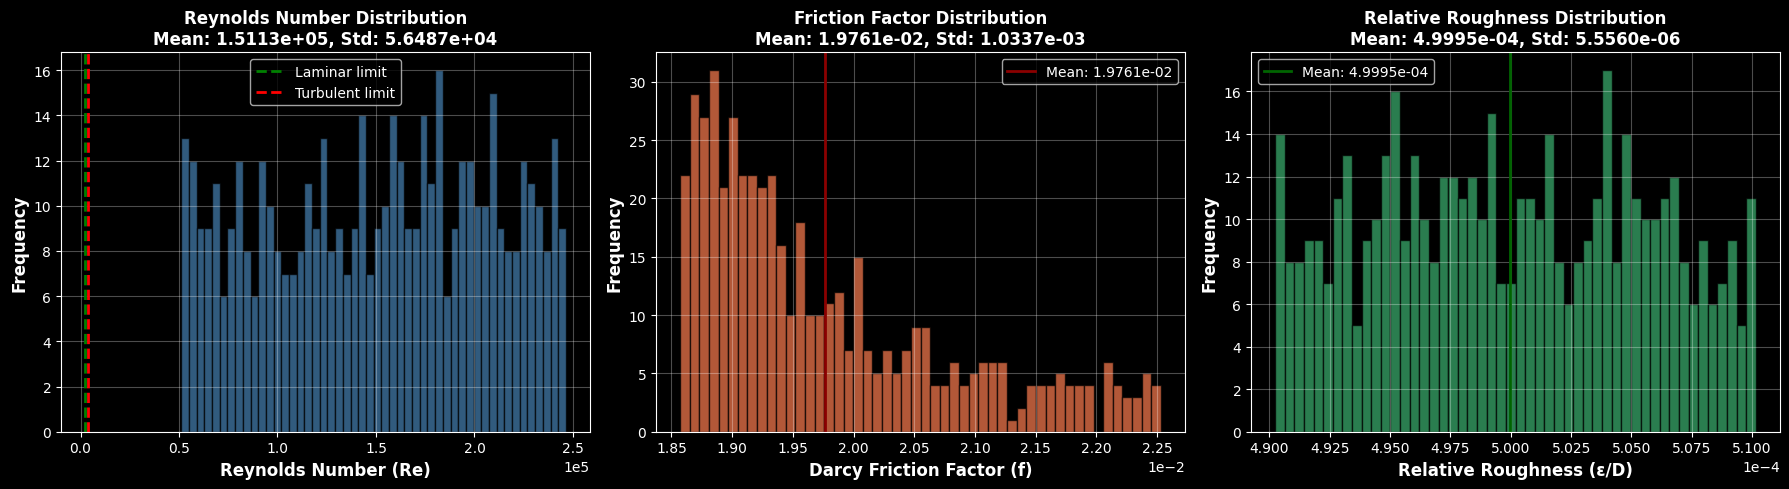

In [68]:
# Plot distributions of the three derived coefficients
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Reynolds Number Distribution
axes[0].hist(Re_sim, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[0].axvline(2300, color="green", linestyle="--", linewidth=2, label="Laminar limit")
axes[0].axvline(4000, color="red", linestyle="--", linewidth=2, label="Turbulent limit")
axes[0].set_xlabel("Reynolds Number (Re)", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
title = f"Reynolds Number Distribution\nMean: {np.mean(Re_sim):.4e}, Std: {np.std(Re_sim):.4e}"
axes[0].set_title(title, fontsize=12, fontweight="bold")
axes[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Friction Factor Distribution
axes[1].hist(f_sim, bins=50, color="coral", alpha=0.7, edgecolor="black")
axes[1].axvline(np.mean(f_sim), color="darkred", linestyle="-", linewidth=2, label=f"Mean: {np.mean(f_sim):.4e}")
axes[1].set_xlabel("Darcy Friction Factor (f)", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
title = f"Friction Factor Distribution\nMean: {np.mean(f_sim):.4e}, Std: {np.std(f_sim):.4e}"
axes[1].set_title(title, fontsize=12, fontweight="bold")
axes[1].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Relative Roughness Distribution
axes[2].hist(epsilon_D_sim, bins=50, color="mediumseagreen", alpha=0.7, edgecolor="black")
axes[2].axvline(np.mean(epsilon_D_sim), color="darkgreen", linestyle="-", linewidth=2, 
                label=f"Mean: {np.mean(epsilon_D_sim):.4e}")
axes[2].set_xlabel("Relative Roughness (ε/D)", fontsize=12, fontweight="bold")
axes[2].set_ylabel("Frequency", fontsize=12, fontweight="bold")
title = f"Relative Roughness Distribution\nMean: {np.mean(epsilon_D_sim):.4e}, Std: {np.std(epsilon_D_sim):.4e}"
axes[2].set_title(title, fontsize=12, fontweight="bold")
axes[2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Plot Moody Diagram Using Simulation Data

Now we'll use the Monte Carlo simulation data to plot our points on a Moody-style diagram, overlaid with theoretical lines.

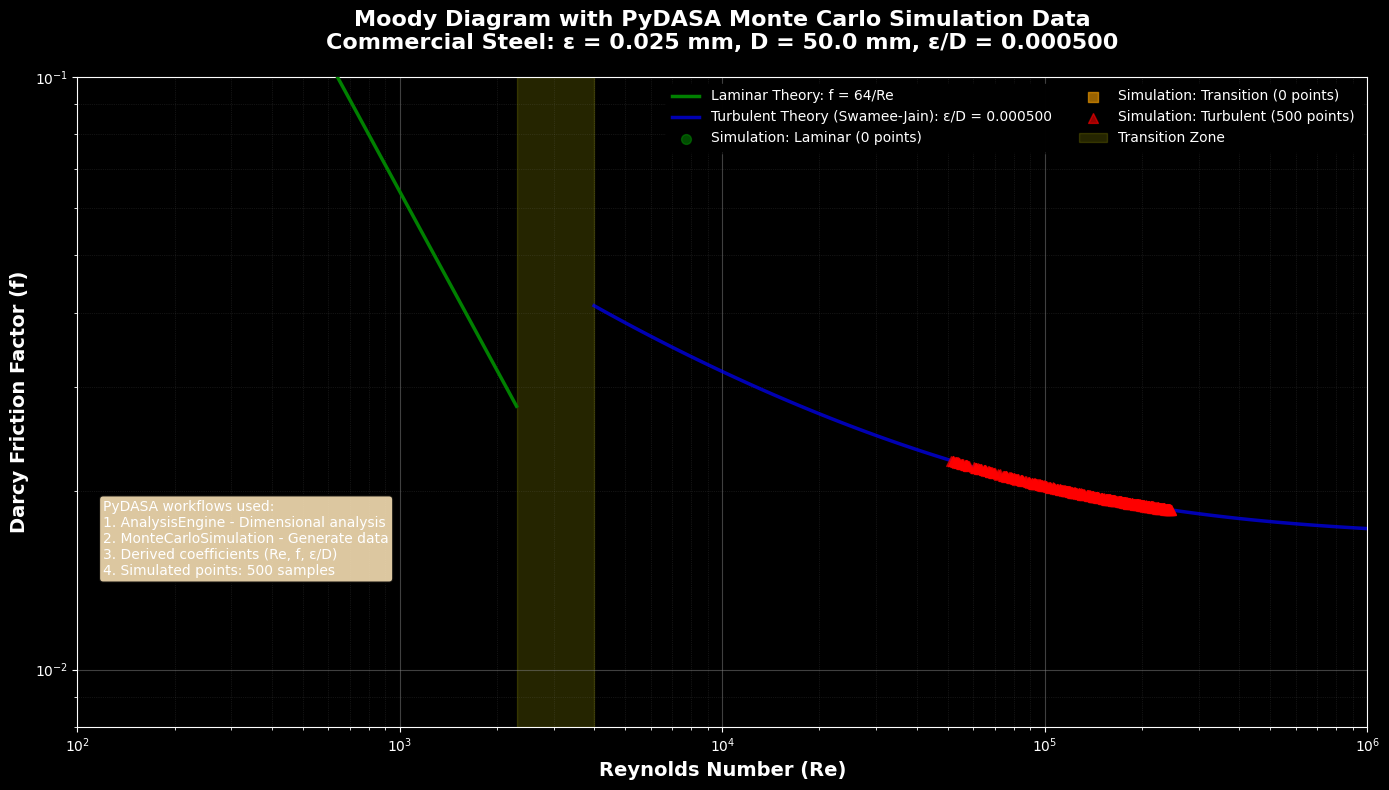

In [69]:
# Create Moody diagram with simulation data
fig, ax = plt.subplots(figsize=(14, 8))

# Get mean values from simulation data for theoretical curves
epsilon_mean = variables["\\varepsilon"].setpoint
D_mean = variables["D"].setpoint
rel_rough = epsilon_mean / D_mean

# Separate simulated data by flow regime
laminar_mask = Re_sim < 2300
transition_mask = (Re_sim >= 2300) & (Re_sim < 4000)
turbulent_mask = Re_sim >= 4000

# 1. Plot THEORETICAL laminar line: f = 64/Re
Re_laminar_theory = np.logspace(2, np.log10(2300), 50)
f_laminar_theory = 64 / Re_laminar_theory
ax.loglog(Re_laminar_theory, f_laminar_theory, "g-", linewidth=2.5, 
          label="Laminar Theory: f = 64/Re", zorder=3)

# 2. Plot THEORETICAL turbulent line for our roughness (Swamee-Jain)
Re_turb_theory = np.logspace(np.log10(4000), np.log10(1e6), 100)
f_turb_theory = 0.25 / (np.log10(rel_rough/3.7 + 5.74/Re_turb_theory**0.9))**2
ax.loglog(Re_turb_theory, f_turb_theory, "b-", linewidth=2.5, 
          label=f"Turbulent Theory (Swamee-Jain): ε/D = {rel_rough:.6f}", zorder=3, alpha=0.7)

# 3. Plot SIMULATED data points (overlaid to validate theory)
ax.scatter(Re_sim[laminar_mask], f_sim[laminar_mask], 
          s=50, c="green", alpha=0.6, marker="o", 
          label=f"Simulation: Laminar ({laminar_count} points)", zorder=4)

ax.scatter(Re_sim[transition_mask], f_sim[transition_mask], 
          s=50, c="orange", alpha=0.6, marker="s", 
          label=f"Simulation: Transition ({transition_count} points)", zorder=4)

ax.scatter(Re_sim[turbulent_mask], f_sim[turbulent_mask], 
          s=50, c="red", alpha=0.6, marker="^", 
          label=f"Simulation: Turbulent ({turbulent_count} points)", zorder=4)

# 4. Shade transition zone
ax.axvspan(2300, 4000, alpha=0.15, color="yellow", label="Transition Zone", zorder=1)

# 5. Format axes
ax.set_xlabel("Reynolds Number (Re)", fontsize=14, fontweight="bold")
ax.set_ylabel("Darcy Friction Factor (f)", fontsize=14, fontweight="bold")
ax.set_title(f"Moody Diagram with PyDASA Monte Carlo Simulation Data\n" + 
             f"Commercial Steel: ε = {epsilon_mean*1000:.3f} mm, D = {D_mean*1000:.1f} mm, ε/D = {rel_rough:.6f}",
             fontsize=16, fontweight="bold", pad=20)

# 6. Set axis limits
ax.set_xlim(100, 1e6)
ax.set_ylim(0.008, 0.1)

# 7. Add grid
ax.grid(True, which="major", ls="-", linewidth=0.8, alpha=0.5, color="gray")
ax.grid(True, which="minor", ls=":", linewidth=0.5, alpha=0.3, color="gray")

# 8. Add legend
ax.legend(loc="upper right", fontsize=10, framealpha=0.95, 
          edgecolor="black", shadow=True, ncol=2)

# 9. Add annotation
textstr = ("PyDASA workflows used:\n"
           "1. AnalysisEngine - Dimensional analysis\n"
           "2. MonteCarloSimulation - Generate data\n"
           "3. Derived coefficients (Re, f, ε/D)\n"
           f"4. Simulated points: {len(Re_sim)} samples")
props = dict(boxstyle="round", facecolor="wheat", alpha=0.9, edgecolor="black", linewidth=1.5)
ax.text(0.02, 0.35, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment="top", bbox=props)

plt.tight_layout()
plt.show()

## 10 . Analyze Sensitivity Result Visually

Finally, let's visualize the sensitivity analysis results for key dimensionless coefficients: Reynolds Number (Re), Pressure Drop (Pd), and Relative Roughness (ε/D).

We'll create one type of visualization for the numeric sensitivity analysis. It shows first-order (S1) and total-order (ST) sensitivity indices from FAST method

In [75]:
# Run numerical sensitivity analysis for confidence intervals
print("\n--- Running Numerical Sensitivity Analysis (FAST Method) ---")
numerical_results = sensitivity.analyze_numeric(n_samples=1000)

print(f"===== ✓ Numerical sensitivity analysis complete! =====")
print(f"\tAnalyzed {len(numerical_results)} coefficients")
print(f"\tResults available for: {list(numerical_results.keys())}")

# Display numerical sensitivity analysis results with confidence intervals
print("\n" + "=" * 120)
print("NUMERICAL SENSITIVITY ANALYSIS RESULTS - FAST Method with Confidence Intervals")
print("=" * 120)

# Only display derived coefficients: Re, Pd, and ε/D
derived_coeffs = ['SEN_{Re}', 'SEN_{Pd}', 'SEN_{\\epsilon/D}']
for coeff_key in derived_coeffs:
    if coeff_key not in numerical_results:
        continue
        
    num_data = numerical_results[coeff_key]

    # Get coefficient name
    if coeff_key in engine.coefficients:
        coeff_name = engine.coefficients[coeff_key].name
    else:
        coeff_name = coeff_key

    print(f"\n{'Coefficient':<25} {coeff_key:<20} ({coeff_name})")
    print("-" * 120)

    # Check if we have FAST results (S1, ST, etc.)
    if 'S1' in num_data and 'ST' in num_data and 'names' in num_data:
        var_names = num_data['names']
        S1_vals = num_data['S1']
        ST_vals = num_data['ST']
        S1_conf = num_data.get('S1_conf', [0] * len(var_names))
        ST_conf = num_data.get('ST_conf', [0] * len(var_names))

        print(f"{'Variable':<20} {'First-Order (S1)':<25} {'Total-Order (ST)':<25} {'S1 Confidence':<20} {'ST Confidence':<20}")
        print("-" * 120)

        for i, var_name in enumerate(var_names):
            s1 = S1_vals[i] if i < len(S1_vals) else 0
            st = ST_vals[i] if i < len(ST_vals) else 0
            s1_c = S1_conf[i] if i < len(S1_conf) else 0
            st_c = ST_conf[i] if i < len(ST_conf) else 0

            print(
                f"{var_name:<20} {s1:<25.6f} {st:<25.6f} {s1_c:<20.6f} {st_c:<20.6f}")

print("\n" + "=" * 120)


--- Running Numerical Sensitivity Analysis (FAST Method) ---
===== ✓ Numerical sensitivity analysis complete! =====
	Analyzed 7 coefficients
	Results available for: ['SEN_{\\Pi_{0}}', 'SEN_{\\Pi_{1}}', 'SEN_{\\Pi_{2}}', 'SEN_{\\Pi_{3}}', 'SEN_{Re}', 'SEN_{Pd}', 'SEN_{\\epsilon/D}']

NUMERICAL SENSITIVITY ANALYSIS RESULTS - FAST Method with Confidence Intervals

Coefficient               SEN_{Re}             (SEN_{Re})
------------------------------------------------------------------------------------------------------------------------
Variable             First-Order (S1)          Total-Order (ST)          S1 Confidence        ST Confidence       
------------------------------------------------------------------------------------------------------------------------
D                    0.000251                  0.000391                  0.015175             0.041598            
\mu                  0.897042                  0.942684                  0.016286             0.039400   

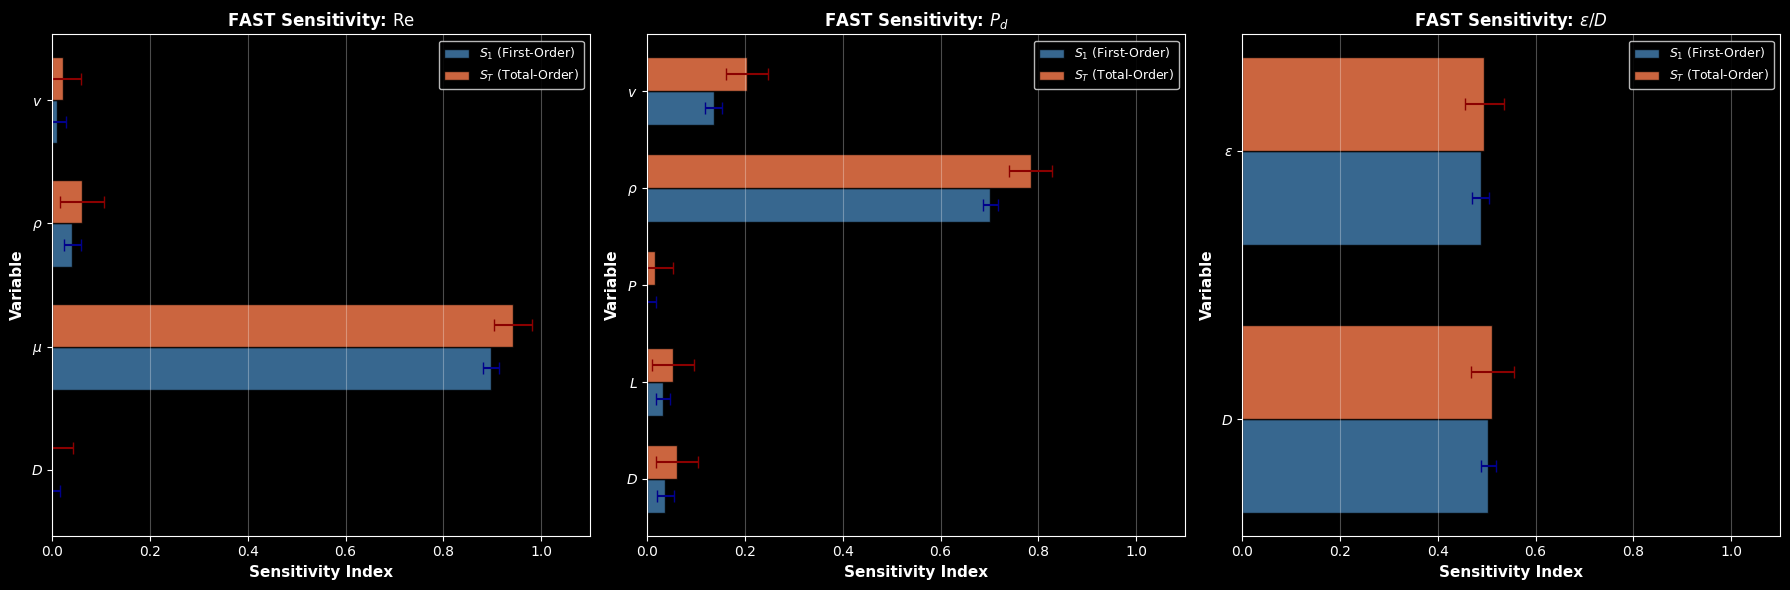

In [79]:
# Visualization: Bar chart of FAST sensitivities for key coefficients
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define exactly which coefficients to plot: Reynolds, Pressure Drop, Relative Roughness
plot_coeffs = ["SEN_{Re}", "SEN_{Pd}", "SEN_{\\epsilon/D}"]

# Mapping for LaTeX-rendered titles
coeff_titles = {
    "SEN_{Re}": r"$\mathrm{Re}$",
    "SEN_{Pd}": r"$P_d$",
    "SEN_{\\epsilon/D}": r"$\varepsilon/D$"
}

# NUMERICAL SENSITIVITY (FAST with Confidence Intervals)
for idx, coeff_key in enumerate(plot_coeffs):
    if coeff_key in numerical_results:
        num_data = numerical_results[coeff_key]
        
        # Check if we have FAST results
        if "S1" in num_data and "ST" in num_data and "names" in num_data:
            # Extract FAST sensitivity data
            var_names = num_data["names"]  # Y-axis labels
            S1_vals = np.array(num_data["S1"])  # First-order sensitivity (X-axis)
            ST_vals = np.array(num_data["ST"])  # Total-order sensitivity (X-axis)
            S1_conf = np.array(num_data.get("S1_conf", [0] * len(var_names)))  # Error bars for S1
            ST_conf = np.array(num_data.get("ST_conf", [0] * len(var_names)))  # Error bars for ST
            
            # Create positions for grouped horizontal bars
            y_pos = np.arange(len(var_names))
            bar_height = 0.35
            
            # Plot S1 (First-order) bars with error bars
            axes[idx].barh(y_pos - bar_height/2, S1_vals, bar_height, 
                            label=r"$S_1$ (First-Order)", color="steelblue", 
                            alpha=0.8, edgecolor="black", linewidth=1,
                            xerr=S1_conf, capsize=4, ecolor="darkblue")
            
            # Plot ST (Total-order) bars with error bars
            axes[idx].barh(y_pos + bar_height/2, ST_vals, bar_height,
                            label=r"$S_T$ (Total-Order)", color="coral",
                            alpha=0.8, edgecolor="black", linewidth=1,
                            xerr=ST_conf, capsize=4, ecolor="darkred")
            
            # Format axes with LaTeX-rendered variable names
            axes[idx].set_yticks(y_pos)
            # Wrap variable names in $ for LaTeX rendering
            latex_var_names = [f"${name}$" for name in var_names]
            axes[idx].set_yticklabels(latex_var_names, fontsize=10)
            axes[idx].set_xlabel("Sensitivity Index", fontsize=11, fontweight="bold")
            axes[idx].set_ylabel("Variable", fontsize=11, fontweight="bold")
            
            # Set title with LaTeX-rendered coefficient symbol
            coeff_label = coeff_titles.get(coeff_key, coeff_key)
            axes[idx].set_title(f"FAST Sensitivity: {coeff_label}",
                                fontsize=12, fontweight="bold")
            axes[idx].grid(True, alpha=0.3, axis="x")
            axes[idx].legend(loc="best", fontsize=9, framealpha=0.9)
            axes[idx].set_xlim(0, max(1.1, np.max(ST_vals) * 1.15))

plt.tight_layout()
plt.show()

## 10. Summary and Key Takeaways

### What We Accomplished

This notebook demonstrated PyDASA's dimensional analysis workflows using Reynolds number and pipe flow as a practical example:

1. **Dimensional Analysis**: Defined 7 physical variables and automatically derived 4 dimensionless Pi groups using Buckingham Pi theorem
2. **Coefficient Derivation**: Created physically meaningful coefficients (Re, Pd, ε/D) from Pi groups using algebraic expressions
3. **Sensitivity Analysis**: 
   - Symbolic analysis showing partial derivatives at mean values
   - Numerical FAST method (1000 samples) providing variance-based sensitivity indices with 95% confidence intervals
4. **Monte Carlo Simulation**: Generated 500 samples to quantify uncertainty and validate theoretical correlations
5. **Visualization**: Created Moody diagram and FAST sensitivity plots with error bars for three key coefficients

### Key PyDASA Workflows

```python
# 1. Dimensional Analysis
engine = AnalysisEngine(...)
engine.run_analysis()

# 2. Derive Coefficients
Re = engine.derive_coefficient(expr="1/Π₀", symbol="Re", ...)

# 3. Sensitivity Analysis
sensitivity = SensitivityAnalysis(...)
numerical_results = sensitivity.analyze_numeric(n_samples=1000)

# 4. Monte Carlo Simulation
mc = MonteCarloSimulation(_experiments=500, ...)
mc.run_simulation(iters=500)
```

### Features Demonstrated

✓ Automatic dimensionless group generation  
✓ Symbolic and numerical sensitivity analysis  
✓ FAST method with confidence intervals  
✓ Monte Carlo uncertainty quantification  
✓ LaTeX rendering in visualizations

### Next Steps

Explore other dimensional analysis problems (drag, heat transfer, etc.) or check [PyDASA Documentation](https://pydasa.readthedocs.io) for advanced features.

---

**About this notebook**: Created to demonstrate PyDASA's dimensional analysis workflows using the classic Reynolds number example. For more examples and documentation, visit [PyDASA on GitHub](https://github.com/DASA-Design/PyDASA) or [Read the Docs](https://pydasa.readthedocs.io).